## Sequential Recommender System

The majority of the models that we have seen (IBCF, Content-Based, NCF) do not model user's short-term behaviour. These models assume the task of the recommender system to be a simple one-to-one mapping between items and ratings. They ignore the interactions between the items.

### Why do we need sequential recommender systems?

For example, when a user goes to the grocery store and buys milk and bread, the next item they will buy will likely be eggs. Traditional recommender systems do not model these kinds of short-term relations.


### What changes do we need to make?

We need to modify the input. Previously, our input was a simple table of user IDs, item IDs and ratings. Now, the input will be ordered; it will be a list of items interacted with by the user, and they will be sorted with respect to the timestamp.

Reference:
https://arxiv.org/pdf/1809.07426.pdf
https://github.com/graytowne/caser_pytorch

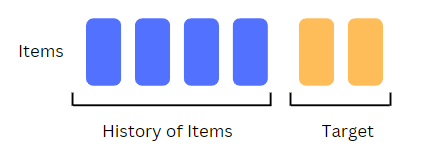

Instead of predicting a simple rating, our task has become slightly more complicated. We need to predict which item the user will interact with, given the user's complete history.

We will look at a versatile model called the CASER model that uses convolutional neural networks to model this behavior.

Note: You create your architecture using LSTM, which can model the long-term and short-term behaviour of the user.


### Convolutional Sequence Embedding Recommendation Model (CASER).

CASER uses Convolutional Neural Networks (CNNs) to capture the temporal relation. It has three main components.

1. Horizontal CNN
2. Vertical CNN
3. Feed-forward Layer.

Let's look at the high-level architecture of CASER.

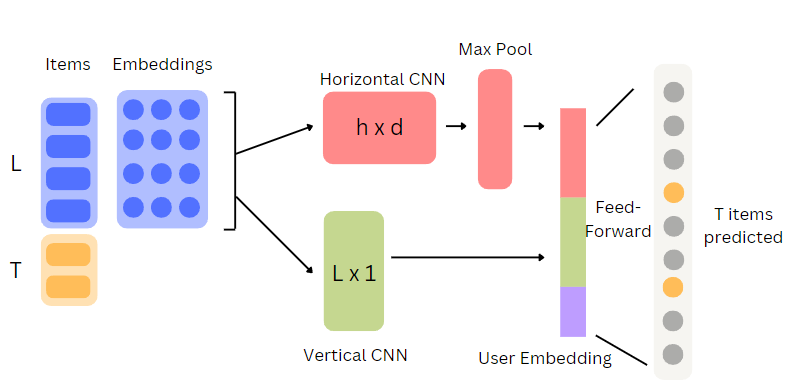

The data is prepared as follows:

Given L history of items, predict T items.

We embed each item into a d-dimensional vector and feed it into our pipeline.

1. Horizontal CNN has a kernel size of h x d where h < L. The intuition of horizontal CNN is that we want to capture the union-level pattern. i.e., the impact of a group of items on predicting the next item (remember the grocery store example).

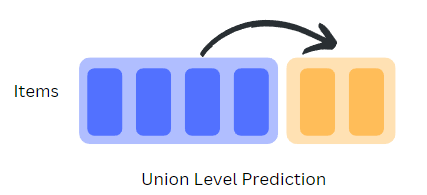

2. Vertical CNN has a kernel size of L x 1. The idea of this layer is that it captures point-wise sequence patterns. i.e. the contribution of each item in the historical sequence.

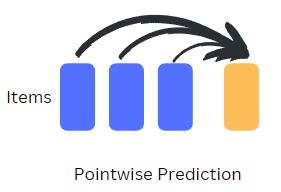

3. Finally, we concat each item embeddings along with the user embedding and put it into a feed-forward layer. This layer will capture the general interests and long-term preferences of the user.

Let's look at how to code this using the recommenders library.

<font size=1> Content of the notebook is taken from the following repository: https://github.com/microsoft/recommenders/tree/main/recommenders </font>

### Setting up the environment (~4mins)

In [ ]:
# This is only necessary for colab since it only supports python 3.10, but the library we are using only supports <= 3.9.
# Comment this section if you are running it on your local machine

!sudo rm -rf /usr/local/lib/python3.8/dist-packages/OpenSSL
!sudo rm -rf /usr/local/lib/python3.8/dist-packages/pyOpenSSL-22.1.0.dist-info/

!wget https://repo.anaconda.com/miniconda/Miniconda3-py39_23.5.2-0-Linux-x86_64.sh
!chmod +x Miniconda3-py39_23.5.2-0-Linux-x86_64.sh

!bash ./Miniconda3-py39_23.5.2-0-Linux-x86_64.sh -b -f -p /usr/local
import sys
sys.path.append('/usr/local/lib/python3.9/site-packages/')
!pip3 install pyOpenSSL==22.0.0

# Installing the recommenders library.
# Ensure that you have python version <=3.9 when installing this.
!pip install recommenders[examples]

### Importing libraries

In [ ]:
import sys
import os
import numpy as np
import tensorflow.compat.v1 as tf
tf.get_logger().setLevel('ERROR') # only show error messages

from recommenders.utils.timer import Timer
from recommenders.utils.constants import SEED
from recommenders.models.deeprec.deeprec_utils import (
    prepare_hparams
)
from recommenders.datasets.amazon_reviews import download_and_extract, data_preprocessing
from recommenders.datasets.download_utils import maybe_download

from recommenders.models.deeprec.models.sequential.caser import CaserModel as SeqModel

from recommenders.models.deeprec.io.sequential_iterator import SequentialIterator

print("System version: {}".format(sys.version))
print("Tensorflow version: {}".format(tf.__version__))

System version: 3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]
Tensorflow version: 2.14.0


In [ ]:
# Downloading the config file for the model.
# Feel free to change the values in the config file and see the performance difference

!wget https://raw.githubusercontent.com/recommenders-team/recommenders/main/recommenders/models/deeprec/config/caser.yaml

In [ ]:
SEED = 42
EPOCHS = 10
BATCH_SIZE = 400
RANDOM_SEED = SEED  # Set None for non-deterministic result

data_path = os.path.join("..", "..", "tests", "resources", "deeprec", "caser")

### Downloading Amazon Data (~4mins)

We will be working with the amazon reviews dataset.

The input data contains 8 columns: `<label> <user_id> <item_id> <category_id> <timestamp> <history_item_ids> <history_cateory_ids> <hitory_timestamp>`

In [ ]:
# Defining the paths for train and test data
train_file = os.path.join(data_path, r'train_data')
valid_file = os.path.join(data_path, r'valid_data')
test_file = os.path.join(data_path, r'test_data')
user_vocab = os.path.join(data_path, r'user_vocab.pkl')
item_vocab = os.path.join(data_path, r'item_vocab.pkl')
cate_vocab = os.path.join(data_path, r'category_vocab.pkl')
output_file = os.path.join(data_path, r'output.txt')

reviews_name = 'reviews_Movies_and_TV_5.json'
meta_name = 'meta_Movies_and_TV.json'
reviews_file = os.path.join(data_path, reviews_name)
meta_file = os.path.join(data_path, meta_name)
train_num_ngs = 4 # number of negative instances with a positive instance for training
valid_num_ngs = 4 # number of negative instances with a positive instance for validation
test_num_ngs = 9 # number of negative instances with a positive instance for testing
sample_rate = 0.01 # sample a small item set for training and testing here for fast example

input_files = [reviews_file, meta_file, train_file, valid_file, test_file, user_vocab, item_vocab, cate_vocab]

# Downloading the data from the net
if not os.path.exists(train_file):
    download_and_extract(reviews_name, reviews_file)
    download_and_extract(meta_name, meta_file)

    #Preprocessing the data into the desired format
    data_preprocessing(*input_files, sample_rate=sample_rate, valid_num_ngs=valid_num_ngs, test_num_ngs=test_num_ngs)

In [ ]:
# Preparing the hyperparameters for the model

hparams = prepare_hparams("./caser.yaml",
                          embed_l2=0.,
                          layer_l2=0.,
                          learning_rate=0.001,  # set to 0.01 if batch normalization is disable
                          epochs=EPOCHS,
                          batch_size=BATCH_SIZE,
                          show_step=20,
                          MODEL_DIR=os.path.join(data_path, "model/"),
                          SUMMARIES_DIR=os.path.join(data_path, "summary/"),
                          user_vocab=user_vocab,
                          item_vocab=item_vocab,
                          cate_vocab=cate_vocab,
                          need_sample=True,
                          train_num_ngs=train_num_ngs, # provides the number of negative instances for each positive instance for loss computation.
            )

In [ ]:
# Initializing the data iterator and the Sequence Model

input_creator = SequentialIterator
model = SeqModel(hparams, input_creator, seed=RANDOM_SEED)

/usr/local/lib/python3.9/site-packages/recommenders/models/deeprec/models/sequential/caser.py:102: UserWarning: `tf.layers.conv1d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv1D` instead.
  return tf.compat.v1.layers.conv1d(
/usr/local/lib/python3.9/site-packages/recommenders/models/deeprec/models/sequential/caser.py:66: UserWarning: `tf.layers.flatten` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Flatten` instead.
  out_v = tf.compat.v1.layers.flatten(out_v)
/usr/local/lib/python3.9/site-packages/recommenders/models/deeprec/models/base_model.py:701: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  curr_hidden_nn_layer = tf.compat.v1.layers.batch_nor

In [ ]:
# Checking the performance without any training

print(model.run_eval(test_file, num_ngs=test_num_ngs))

# You can see that the AUC value is ~.5 which means random guessing

{'auc': 0.5082, 'logloss': 0.6932, 'mean_mrr': 0.2862, 'ndcg@2': 0.1474, 'ndcg@4': 0.2521, 'ndcg@6': 0.3265, 'group_auc': 0.5164}


In [ ]:
# Training the mdoel on train and validating using the valid_file

with Timer() as train_time:
    model = model.fit(train_file, valid_file, valid_num_ngs=valid_num_ngs)

print('Time cost for training is {0:.2f} mins'.format(train_time.interval/60.0))

In [ ]:
# Model performance after training

res_syn = model.run_eval(test_file, num_ngs=test_num_ngs)
print(res_syn)

# AUC and NDCG have increased greatly, try changing the hyperparameters to achieve a greater score

{'auc': 0.6883, 'logloss': 1.1347, 'mean_mrr': 0.4673, 'ndcg@2': 0.3744, 'ndcg@4': 0.4662, 'ndcg@6': 0.5292, 'group_auc': 0.6822}
